In [1]:
# ensure we can import from project root
import sys, os
sys.path.append("..")  # so we can import from ../piqs_utils

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# our utils
from utils.piqs_util import simulate_piqs_dynamics
from utils.measurement_util import qfi_from_state_triplet, extract_lambda


In [2]:
# global simulation constants
T1 = 1.0
T2 = 1.0
gamma_c_prefactor = 0.2
v_detuning = 10.0
t_max = 6.0
n_t = 80
tlist = np.linspace(0.0, t_max, n_t)
Ns = list(range(20, 30, 1))  # number of atoms to sweep
eps_rel = 1e-3  # small detuning step for finite difference

np.random.seed(0)


In [3]:
peak_QFIs = []
decay_lams = []
Ns_done = []

gamma_c_global = gamma_c_prefactor / T1

for N in tqdm(Ns, desc="Scanning N values"):
    try:
        gamma_c = gamma_c_global
        w = (N * gamma_c) / 2.0
        E =  max(1e-4, eps_rel*abs(v_detuning))

        # simulate at v-E, v+E, and v
        res_minus = simulate_piqs_dynamics(N, T1, T2, gamma_c, w, v_detuning - E, tlist, return_states=True)
        res_plus  = simulate_piqs_dynamics(N, T1, T2, gamma_c, w, v_detuning + E, tlist, return_states=True)
        res_center= simulate_piqs_dynamics(N, T1, T2, gamma_c, w, v_detuning,      tlist, return_states=True)

        # compute QFI(t)
        F_t = qfi_from_state_triplet(res_minus['states'], res_plus['states'], res_center['states'], E)
        peak_QFI = float(np.nanmax(F_t)) if len(F_t) > 0 else np.nan

        # extract decay rate λ from ⟨Jx⟩(t)
        lam = extract_lambda(res_center['tlist'], res_center['Jx'])

        peak_QFIs.append(peak_QFI)
        decay_lams.append(lam)
        Ns_done.append(N)

    except Exception as e:
        print(f"Error at N={N}: {e}")
        peak_QFIs.append(np.nan)
        decay_lams.append(np.nan)
        Ns_done.append(N)


Scanning N values:   0%|          | 0/10 [00:00<?, ?it/s]

D:\sync_code\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
D:\sync_code\.venv\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


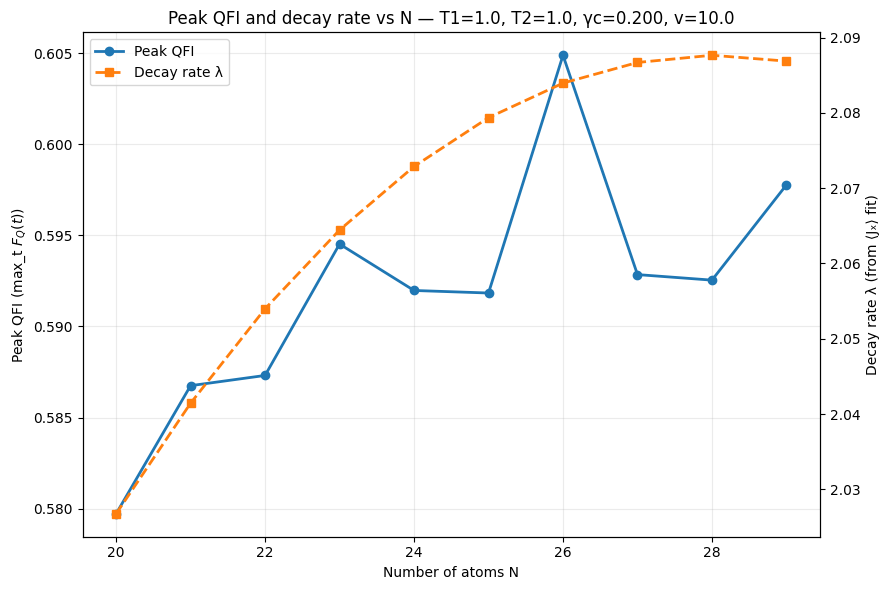

In [4]:
Ns_done = np.array(Ns_done)
peak_QFIs = np.array(peak_QFIs)
decay_lams = np.array(decay_lams)

fig, axL = plt.subplots(figsize=(9,6))
axR = axL.twinx()

# QFI (left axis)
axL.plot(Ns_done, peak_QFIs, "o-", label="Peak QFI", lw=2)
axL.set_ylabel("Peak QFI (max_t $F_Q(t)$)")

# Decay rate λ (right axis)
axR.plot(Ns_done, decay_lams, "s--", color="tab:orange", label="Decay rate λ", lw=2)
axR.set_ylabel("Decay rate λ (from ⟨Jₓ⟩ fit)")

axL.set_xlabel("Number of atoms N")
axL.set_title(f"Peak QFI and decay rate vs N — T1={T1}, T2={T2}, γc={gamma_c_global:.3f}, v={v_detuning}")

# merge legends
lnsL, labsL = axL.get_legend_handles_labels()
lnsR, labsR = axR.get_legend_handles_labels()
axL.legend(lnsL + lnsR, labsL + labsR, loc="upper left")

axL.grid(alpha=0.25)
plt.tight_layout()
plt.show()
